In [35]:
import warnings
import pandas as pd
from sklearn import linear_model, ensemble
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

In [2]:
%%capture
!wget https://www.dropbox.com/s/bbm6rxqb4bsfl2d/training_data.xlsx
!wget https://www.dropbox.com/s/gjhur7eyzcv265y/test_data.xlsx

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
training_data = pd.read_excel('training_data.xlsx', usecols=lambda x: 'Unnamed' not in x)
training_data.head()

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
4,13865,2010,3,8,166062,clean,automatic,4wd,NaN,49.210949,-123.114720,NaN


In [5]:
training_data.shape
training_data.info()
training_data = training_data.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4913 entries, 0 to 4912
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         4913 non-null   int64  
 1   year          4913 non-null   int64  
 2   condition     4913 non-null   int64  
 3   cylinders     4913 non-null   int64  
 4   odometer      4913 non-null   int64  
 5   title_status  4913 non-null   object 
 6   transmission  4913 non-null   object 
 7   drive         4651 non-null   object 
 8   size          3825 non-null   object 
 9   lat           4913 non-null   float64
 10  long          4913 non-null   float64
 11  weather       4801 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 460.7+ KB


In [6]:
training_data.shape

(3659, 12)

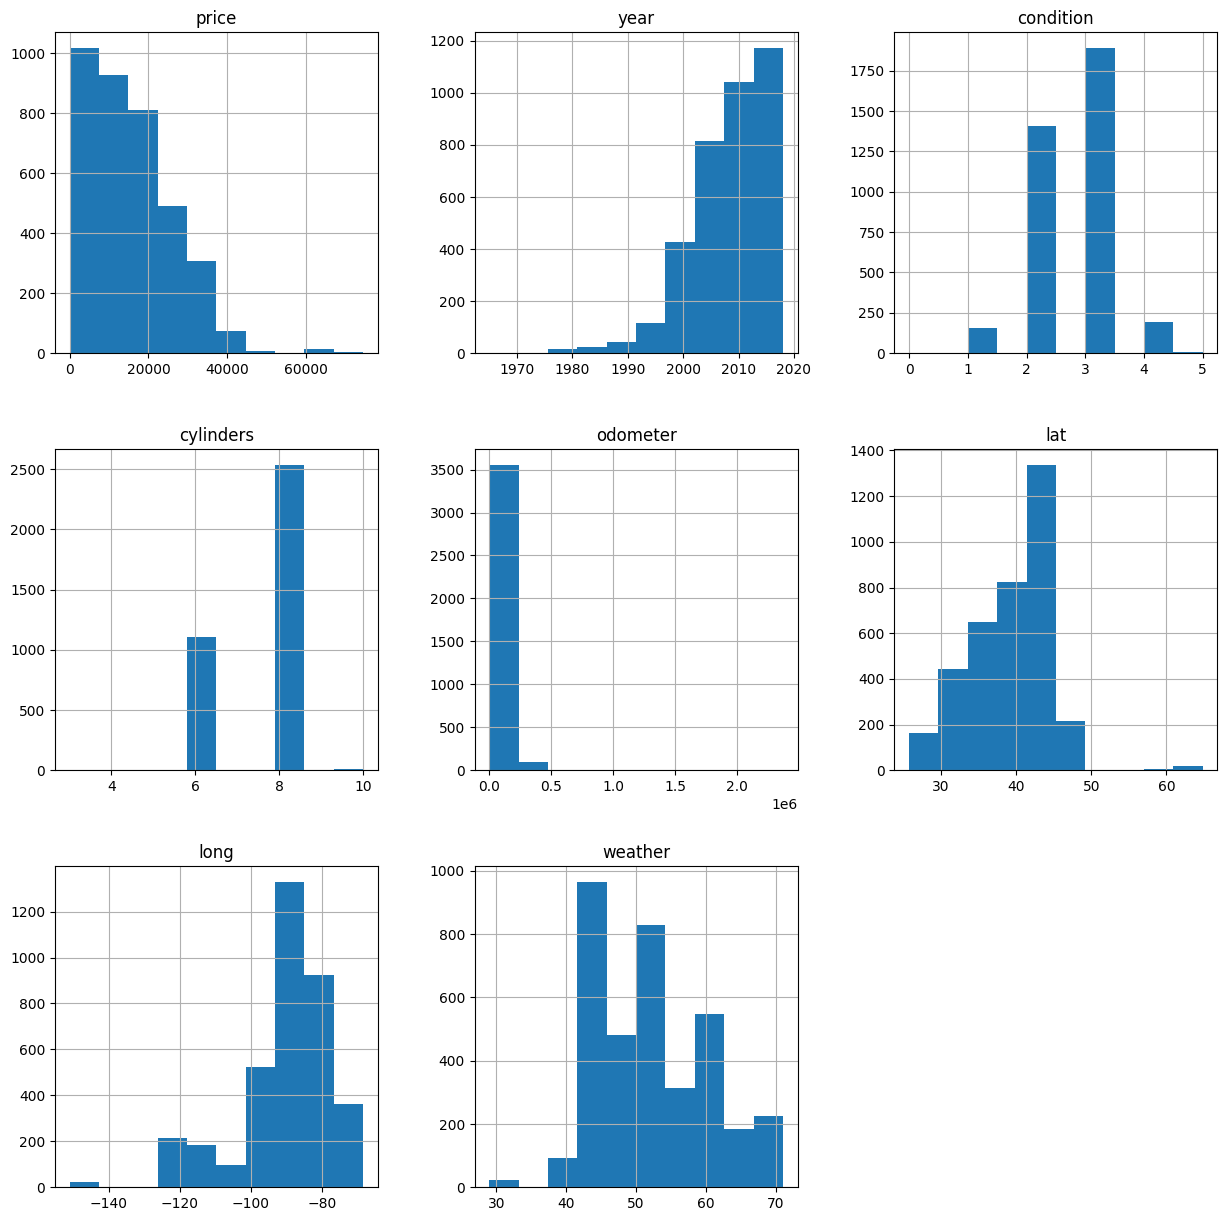

In [7]:
training_data.hist(figsize=(15, 15));

In [8]:
 training_data = pd.concat([training_data,  pd.get_dummies(training_data['title_status'], prefix="title_status"),
                            pd.get_dummies(training_data['transmission'], prefix="transmission"),
                            pd.get_dummies(training_data['drive'], prefix="drive"),
                            pd.get_dummies(training_data['size'], prefix="size")],  axis=1)

In [9]:
training_data.drop(['title_status', 'transmission', 'drive', 'size'], axis=1, inplace=True)
training_data.head()

,price,year,condition,cylinders,odometer,lat,long,weather,title_status_clean,title_status_lien,...,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_rwd,size_compact,size_full-size,size_mid-size,size_sub-compact
0,43900,2016,4,6,43500,36.471500,-82.483400,59.0,1,0,...,1,0,0,1,0,0,0,1,0,0
1,15490,2009,2,8,98131,40.468826,-74.281734,52.0,1,0,...,1,0,0,1,0,0,0,1,0,0
2,2495,2002,2,8,201803,42.477134,-82.949564,45.0,1,0,...,1,0,0,1,0,0,0,1,0,0
3,1300,2000,1,8,170305,40.764373,-82.349503,49.0,0,0,...,1,0,0,1,0,0,0,1,0,0
5,6995,2003,3,8,167662,45.518031,-122.578752,50.0,1,0,...,1,0,0,1,0,0,0,1,0,0


In [10]:
training_values = training_data['price']
training_points = training_data.drop('price', axis=1)
training_points.head()

,year,condition,cylinders,odometer,lat,long,weather,title_status_clean,title_status_lien,title_status_missing,...,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_rwd,size_compact,size_full-size,size_mid-size,size_sub-compact
0,2016,4,6,43500,36.471500,-82.483400,59.0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
1,2009,2,8,98131,40.468826,-74.281734,52.0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
2,2002,2,8,201803,42.477134,-82.949564,45.0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
3,2000,1,8,170305,40.764373,-82.349503,49.0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
5,2003,3,8,167662,45.518031,-122.578752,50.0,1,0,0,...,1,0,0,1,0,0,0,1,0,0


In [11]:
training_points.shape

(3659, 22)

In [12]:
training_points['size_sub-compact'].value_counts(dropna=False)

0    3658
1       1
Name: size_sub-compact, dtype: int64

In [13]:
training_points = training_points.drop('size_sub-compact', axis=1)
training_points.head()

,year,condition,cylinders,odometer,lat,long,weather,title_status_clean,title_status_lien,title_status_missing,...,title_status_salvage,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_rwd,size_compact,size_full-size,size_mid-size
0,2016,4,6,43500,36.471500,-82.483400,59.0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
1,2009,2,8,98131,40.468826,-74.281734,52.0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
2,2002,2,8,201803,42.477134,-82.949564,45.0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,2000,1,8,170305,40.764373,-82.349503,49.0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
5,2003,3,8,167662,45.518031,-122.578752,50.0,1,0,0,...,0,1,0,0,1,0,0,0,1,0


In [15]:
linear_regression_model = linear_model.LinearRegression() # создаем модель

In [16]:
random_forest_model = ensemble.RandomForestRegressor(random_state=123)


In [18]:
linear_regression_model.fit(training_points, training_values)

LinearRegression()

In [19]:
random_forest_model.fit(training_points, training_values)

RandomForestRegressor(random_state=123)

In [20]:
test_data = pd.read_excel('test_data.xlsx', usecols=lambda x: 'Unnamed' not in x)

In [21]:
test_data.head()

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,5990,2004,4,8,210445,clean,automatic,4wd,full-size,38.731803,-90.073678,48.0
1,18995,2015,2,6,142282,clean,automatic,4wd,full-size,42.504823,-92.405569,47.0
2,23500,2012,3,6,100710,clean,automatic,4wd,full-size,36.060541,-95.795447,57.0
3,24988,2012,4,6,85572,clean,automatic,4wd,NaN,30.457703,-84.347448,65.0
4,20995,2014,3,6,157556,clean,automatic,NaN,full-size,42.701772,-89.008858,45.0


In [22]:
test_data.shape

(2104, 12)

In [23]:
test_data = test_data.dropna()

In [24]:
test_data = pd.concat([test_data,  pd.get_dummies(test_data['title_status'], prefix="title_status"),
                            pd.get_dummies(test_data['transmission'], prefix="transmission"),
                            pd.get_dummies(test_data['drive'], prefix="drive"),
                            pd.get_dummies(test_data['size'], prefix="size")],  axis=1)

In [25]:
test_data.drop(['title_status', 'transmission', 'drive', 'size'], axis=1, inplace=True)

In [26]:
test_data.head()

,price,year,condition,cylinders,odometer,lat,long,weather,title_status_clean,title_status_lien,...,title_status_salvage,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_rwd,size_compact,size_full-size,size_mid-size
0,5990,2004,4,8,210445,38.731803,-90.073678,48.0,1,0,...,0,1,0,0,1,0,0,0,1,0
1,18995,2015,2,6,142282,42.504823,-92.405569,47.0,1,0,...,0,1,0,0,1,0,0,0,1,0
2,23500,2012,3,6,100710,36.060541,-95.795447,57.0,1,0,...,0,1,0,0,1,0,0,0,1,0
8,20495,2013,3,6,108500,42.612400,-83.034500,45.0,1,0,...,0,1,0,0,1,0,0,0,1,0
9,6000,2000,3,8,69600,32.832296,-97.169012,67.0,1,0,...,0,1,0,0,0,0,1,0,1,0


In [27]:
test_values = test_data['price']

In [28]:
test_points = test_data.drop('price', axis=1)

In [29]:
test_points.head()

,year,condition,cylinders,odometer,lat,long,weather,title_status_clean,title_status_lien,title_status_missing,...,title_status_salvage,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_rwd,size_compact,size_full-size,size_mid-size
0,2004,4,8,210445,38.731803,-90.073678,48.0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
1,2015,2,6,142282,42.504823,-92.405569,47.0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
2,2012,3,6,100710,36.060541,-95.795447,57.0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
8,2013,3,6,108500,42.612400,-83.034500,45.0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
9,2000,3,8,69600,32.832296,-97.169012,67.0,1,0,0,...,0,1,0,0,0,0,1,0,1,0


In [30]:
test_points.shape

(1543, 21)

In [31]:
list(test_points)==list(training_points)

True

In [38]:
test_predictions_linear = linear_regression_model.predict(test_points)
test_predictions_random_forest = random_forest_model.predict(test_points)

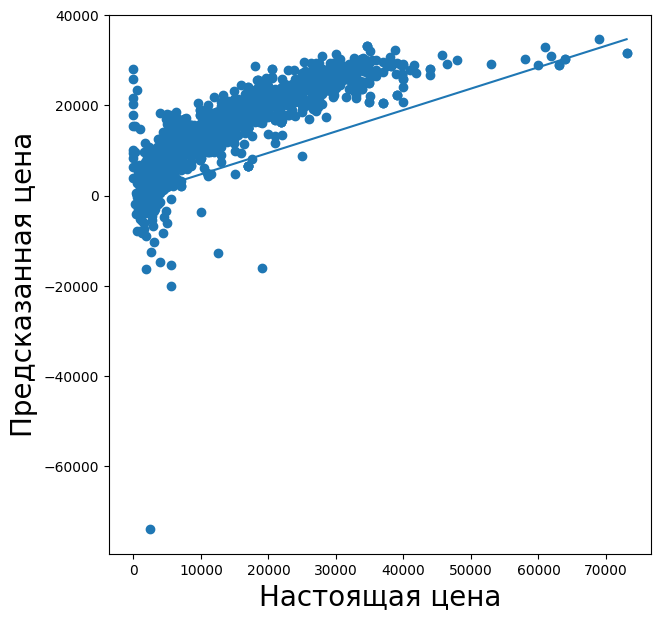

In [39]:
plt.figure(figsize=(7, 7))
plt.scatter(test_values, test_predictions_linear) # рисуем точки, соответствущие парам настоящее значение - прогноз
plt.plot([0, max(test_values)], [0, max(test_predictions_linear)])  # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Настоящая цена', fontsize=20)
plt.ylabel('Предсказанная цена', fontsize=20);

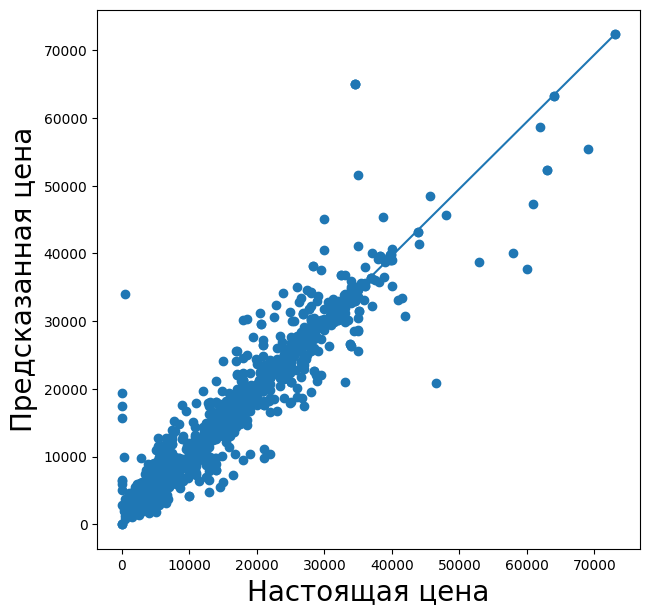

In [40]:
plt.figure(figsize=(7, 7))
plt.scatter(test_values, test_predictions_random_forest) # рисуем точки, соответствущие парам настоящее значение - прогноз
plt.plot([0, max(test_values)], [0, max(test_predictions_random_forest)]) # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Настоящая цена', fontsize=20)
plt.ylabel('Предсказанная цена', fontsize=20);

In [41]:
mean_absolute_error_linear_model = mean_absolute_error(test_values, test_predictions_linear)
mean_squared_error_linear_model = mean_squared_error(test_values, test_predictions_linear)
r2_score_linear_model = r2_score(test_values, test_predictions_linear)
mean_absolute_error_random_forest_model = mean_absolute_error(test_values, test_predictions_random_forest)
mean_squared_error_random_forest_model = mean_squared_error(test_values, test_predictions_random_forest)
r2_score_random_forest_model = r2_score(test_values, test_predictions_random_forest)


In [42]:
print("MAE: {0:7.2f}, RMSE: {1:7.2f}, R2: {2:7.2f} for linear model".format(
        mean_absolute_error(test_values, test_predictions_linear),
        mean_squared_error(test_values, test_predictions_linear)**0.5, r2_score_linear_model))

print("MAE: {0:7.2f}, RMSE: {1:7.2f},  R2: {2:7.2f} for random forest model".format(
       mean_absolute_error(test_values, test_predictions_random_forest),
       mean_squared_error(test_values, test_predictions_random_forest)**0.5, r2_score_random_forest_model))

MAE: 4263.96, RMSE: 6350.82, R2:    0.66 for linear model
MAE: 1673.39, RMSE: 3316.56,  R2:    0.91 for random forest model
